# 1. Describe the data
- It has 50 observations.
- There are 5 variables:
    - sr: Savings rate - the percentage of disposable income that is saved.
    - pop15: Percentage of the population under 15 years old.
    - pop75: Percentage of the population over 75 years old.
    - dpi: Real per capita disposable income.
    - ddpi: Growth rate of real per capita disposable income.

# 2. Load packages and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import faraway.utils

In [3]:
import faraway.datasets.savings
savings = faraway.datasets.savings.load()
savings.head()

,sr,pop15,pop75,dpi,ddpi
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82
Bolivia,5.75,41.89,1.67,189.13,0.22
Brazil,12.88,42.19,0.83,728.47,4.56


# 3. Linear regression

In [4]:
lmod = smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', savings).fit()

# 4. Diagnosis
- Error: $\epsilon \sim N(0, \sigma^2 I)$
- Model: assumption of the structural part of the model E($y$)=$X \beta$
- Unusual observations: Sometimes just a few observations do not fit the model. These few observations might change the choice and fit of the model.
- Diagnostic techniques:
    - Graphical techniques are more flexible but can be harder to interpret definitively. They provide a visual representation of the data, which allows for more flexibility in analyzing it. However, interpreting the results may require more intuition and subjective judgment.
    - Numerical techniques are narrower in scope but require less intuition. They involve performing calculations and statistical analysis on the data. While they may not provide as much flexibility as graphical techniques, they can provide more precise and objective results.
    - When trying to find a good model, the first one we try may not be good enough. This is where regression diagnostics come in. They help us identify specific areas for improvement in the model. Model building is an iterative and interactive process, meaning we make changes to the model based on the diagnostic results and repeat the process until we find a satisfactory model.

## 4.1. Errors
- The errors ε are not observable, but we can examine the residuals $\hat{\epsilon}$. Residuals and errors are related but have slightly different properties.
- To check the independence of errors, we want to ensure that the errors are not influenced by each other. In other words, the occurrence of one error should not affect the occurrence of another error.
- Constant variance refers to the assumption that the variability of errors remains the same across different values of the independent variables.
- Normality of errors means that the errors follow a normal distribution. This assumption is important for many statistical tests and models. If the errors are not normally distributed, it can affect the validity of the statistical analysis.
- $\hat{\epsilon} = y-\hat{y} = (I-H)y = (I-H)\epsilon$
- $var(\hat{\epsilon}) = var[(I-H)\epsilon] = (I-H) σ^2$
    - Assuming $var(\epsilon) = \sigma^2 I$
    - Although the errors ε may have equal variance and be uncorrelated, the residuals $\hat{\epsilon}$ do not. However, the impact of this is small and diagnostics can still be applied to the residuals $\hat{\epsilon}$ to check the assumption on the error ε.

### 4.1.1. Constant variance
- It is not enough to just look at the residuals to determine if the assumption of constant variance is met in a statistical model. The residuals can have both large and small values, but this alone does not provide conclusive evidence. To truly assess the assumption of constant variance, we need to examine whether the variability in the residuals is related to some other factor or quantity.
- The most useful diagnostic is a plot of $\hat{\epsilon}$ again $\hat{y}$. If everything is fine, the plot will show a consistent and symmetrical pattern in the vertical direction ($\hat{\epsilon}$). This pattern is called homoscedasticity, which means that the variability of the model's predictions is the same across different values of $\hat{y}$. If the plot shows an inconsistent or non-symmetrical pattern, it indicates a problem called heteroscedasticity. Additionally, the plot can also help detect nonlinearity in the structural part of the model. If the plot shows a curved or non-linear pattern, it suggests that the model may not be capturing the true relationship between the variables accurately.

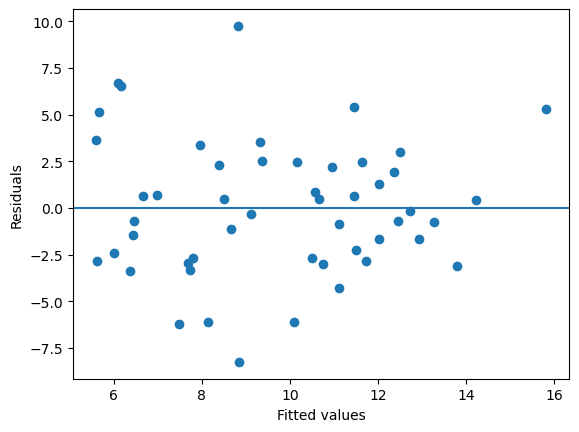

In [43]:
plt.scatter(lmod.fittedvalues, lmod.resid)
plt.ylabel("Residuals"); plt.xlabel("Fitted values"); plt.axhline(0);

We see no cause for alarm in this plot. If we would like to examine the constant variance assumption more closely, it helps to plot $\sqrt{|\hat{ε}|}$ against $\hat{y}$.

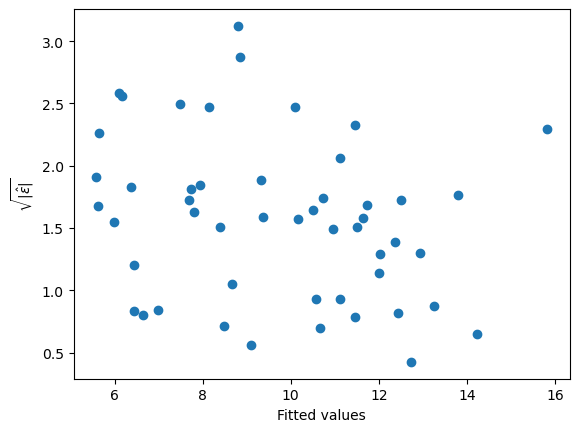

In [44]:
plt.scatter(lmod.fittedvalues, np.sqrt(abs(lmod.resid)))
plt.ylabel(r'$\sqrt{|\hat{ε}|}$'); plt.xlabel("Fitted values");

A quick numerical test to check nonconstant variance can be achieved using this regression where we check whether the size of $\sqrt{|\hat{\epsilon}|}$ is changing with the fitted values.

In [45]:
ddf = pd.DataFrame({'x':lmod.fittedvalues, 'y':np.sqrt(abs(lmod.resid))})
dmod = smf.ols('y ~ x', ddf).fit()
dmod.sumary()

           coefs stderr tvalues pvalues
Intercept  2.162  0.348    6.22  0.0000
x         -0.061  0.035   -1.77  0.0838

n=50 p=2 Residual SD=0.634 R-squared=0.06


- This test isn’t quite right. Weighting and adjusting degrees of freedom are needed. However, the slope isn’t statistically significant, so non-constant variance isn’t a clear issue. It only tests for a linear trend in variation, and while it may detect one type of non-constant variance, it might miss others.
- While these tests may seem precise, they may not always be able to detect unexpected problems. Instead, graphical techniques are often more effective at revealing hidden patterns or structures. Although the interpretation of these plots may sometimes be unclear, they can provide assurance that the underlying assumptions are not seriously flawed. As a result, a graphical approach is typically preferred for diagnostics, with formal tests used to further investigate any indications found in the plots.
- Now look at some residuals against predictor plots for the savings data:

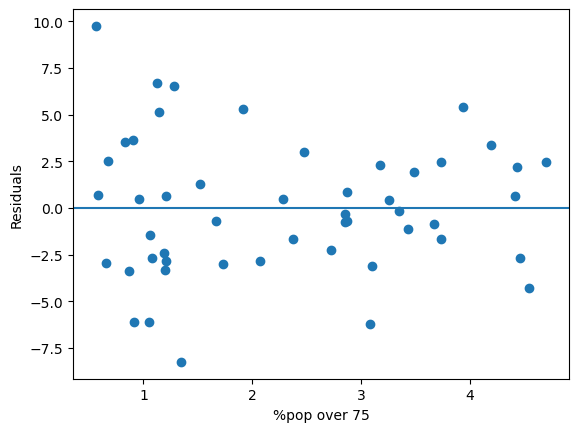

In [46]:
plt.scatter(savings.pop75, lmod.resid)
plt.xlabel("%pop over 75"); plt.ylabel("Residuals"); plt.axhline(0);

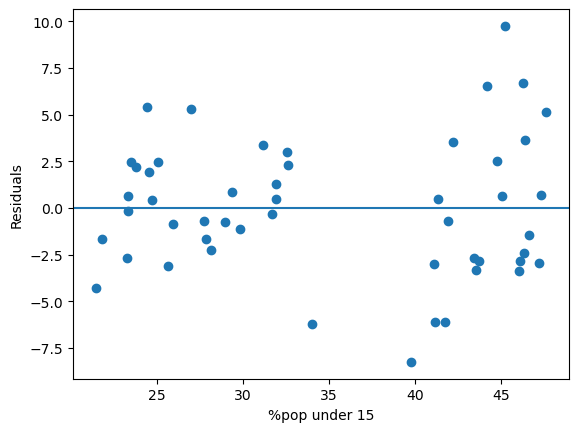

In [47]:
plt.scatter(savings.pop15, lmod.resid)
plt.xlabel("%pop under 15"); plt.ylabel("Residuals"); plt.axhline(0);

- Two groups can be seen in the plot. Let's compare and test the variances in these groups.
    - Given two independent samples from normal distributions, we can test for equal variance using the test statistic of the ratio of the two variances.

In [48]:
numres = lmod.resid[savings.pop15 > 35]
denres = lmod.resid[savings.pop15 < 35]
fstat = np.var(numres, ddof=1)/np.var(denres, ddof=1)
# The ddof parameter in the np.var function stands for "Delta Degrees of Freedom."
# By default, ddof is set to 0, which means the divisor is N, where N is the number of elements.
# When ddof=1, the divisor becomes N-1. 
2*(1 - sp.stats.f.cdf(fstat, len(numres)-1, len(denres)-1))

0.013575950424160377

- If issues are identified in the diagnostic plots, it indicates that some changes need to be made to the model. If there is evidence of non-linearity, possibly along with non-constant variance, it is recommended to consider transforming the variables. The shape of the plot can provide guidance on which transformation to use.
- If the issue is only non-constant variance without any indication of nonlinearity, using weighted least squares or transforming the response variable may be suitable.
- When non-constant variance is observed in the plot of residuals against fitted values, transforming the response variable to a function h(y) can be done to achieve constant variance.
    - The choice of h() should be made to ensure that the variance of h(y) remains constant. To determine the appropriate transformation, consider the expansion provided.
    - $h(y) = h(E(y)) + [y-E(y)]\cdot h'(E(y)) + \cdots$
    - $var[h(y)] = 0 + h'(E(y))^2~var(y) + \cdots$
    - Ignore the higher order terms. For var(h(y)) to be constant we need: $h'(E(y)) \propto \sqrt{var(y)}$
    - It suggests $h(y) = \int \frac{dy}{\sqrt{var(y)}} = \int \frac{dy}{sd(y)}$
    - Example: $var(y) = var(\epsilon) \propto (E(y))^2$, then $h(y) = log(y)$
    - Example: $var(y) = var(\epsilon) \propto E(y)$, then $h(y) = \sqrt{y}$
    - Sometimes, finding a suitable transformation for the data can be challenging. In cases where the response variable has values less than or equal to zero, traditional transformations like square root or log transformations may not work. In such situations, an alternative approach is to try a transformation like log(y + δ), where δ is a small constant. However, using this transformation can make the interpretation of the results more complicated.

### 4.1.2. Normality
- The tests and confidence intervals we use are based on the assumption of normal errors.
- The residuals can be assessed for normality using a Q-Q plot.
- In Q-Q plot, we plot the sorted residuals against $\Phi^{(-1)} (\frac{i}{n+1})$ for i = 1, …, n. Normal residuals should follow the line approximately.

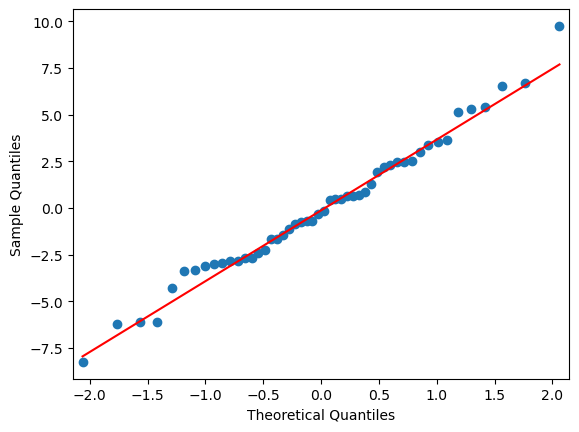

In [49]:
sm.qqplot(lmod.resid, line="q");

Histograms and boxplots aren’t good for checking normality. The histogram in the plot doesn’t show the expected bell shape because the data is grouped into bins. The width and placement of these bins can be tricky, making the plot unclear.

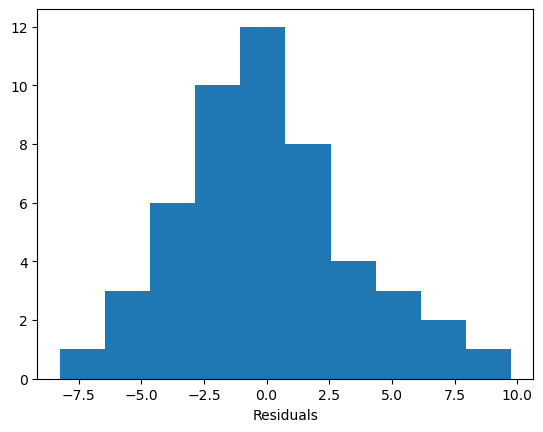

In [50]:
plt.hist(lmod.resid); plt.xlabel("Residuals");

- In Q-Q plots, it can be challenging to identify the exact issue. Occasionally, extreme cases in the plot may indicate a long-tailed error, such as the Cauchy distribution, or they could simply be outliers. If removing these observations only leads to other points becoming more noticeable in the plot, then the problem is likely due to a long-tailed error.
- The Shapiro-Wilk test is a formal test for normality.
    - The null hypothesis is that the residuals are normal. If we do not reject the null hypothesis, the residuals can be normal.
    - The Shapiro–Wilk test is best used with a Q-Q plot. In large datasets, even small deviations from normality can be spotted. However, with large samples, you usually don’t need to abandon the least squares method because the effects of non-normality are minimized. For smaller samples, formal tests might not detect non-normality well, meaning they might miss deviations when the sample size is small.

In [51]:
sp.stats.shapiro(lmod.resid)

ShapiroResult(statistic=0.986984385973169, pvalue=0.8523961877568906)

- When errors in a statistical model aren’t normally distributed, least squares estimates might not be the best, but they’ll still be the best linear unbiased estimates. In these cases, other robust estimators might work better. Tests and confidence intervals assuming normality might not be exact, but thanks to the central limit theorem, they become more accurate with larger sample sizes. So, if the sample size is large enough or the non-normality isn’t severe, we can still get reliable results.
- When we encounter non-normality in our data, the appropriate solution depends on the type of non-normality. If the distribution has a short tail, the impact is minimal and can be ignored. For skewed errors, transforming the response variable might help. However, for long-tailed errors, we may need to accept the non-normality and make inferences based on a different distribution. Alternatively, we can use resampling methods like bootstrap or permutation tests. Another option is to use robust methods that give less weight to outliers, though this may also require resampling for accurate inference.
- It is possible that other diagnostic tests indicate the need for changes to the model. By tackling issues like non-linearity and non-constant variance, we might prevent the problem of non-normal errors. Therefore, it’s advisable to address these issues first before considering the impact of non-normality.

### 4.1.3. Corrected errors
- The Durbin–Watson test is used to assess the significance of correlation in errors. The null hypothesis states that the errors are uncorrelated. Under this assumption, the null distribution follows a linear combination of χ² distributions.
    - $DW = \frac{\sum_{i=2}^{n}{(\hat{\epsilon}_i - \hat{\epsilon}_{i-1})^2} }{\sum_{i=1}^{n}{\hat{\epsilon}_i^2}}$
    - Under the null hypothesis, a test statistic value of 2 is expected. A value less than 1 indicates a potential issue.
- Serial correlation can sometimes result from missing covariates in the model. For instance, if there’s a quadratic relationship between a predictor and the response, but only a linear term is included, diagnostics might show serial correlation in the residuals. In such cases, the missing quadratic term is the actual source of the problem, and including it in the model can help address the serial correlation.

In [52]:
sm.stats.stattools.durbin_watson(lmod.resid)

1.9341492250435388

## 4.2. Unusual observations
- Outliers: they do not fit the model well.
- Influential observations: they affect the model's fit significantly.
- A point can have both characteristics of outliers and influential observations.
- Leverage points: they are extreme in the predictor space and have the potential to influence the fit, but don’t necessarily do so. Identifying these points is crucial, but deciding how to handle them can be challenging.

### 4.2.1. Leverage
- Leverages are $h_i = H_{ii}$ and useful diagnostics.
- $var(\hat{\epsilon}_i) = \sigma^2 (1-h_i)$
    - A large leverage $h_i$ will make $var(\hat{\epsilon}_i)$ small. The fitted value $\hat{y}_i$ will be closer to the observed value $y_i$.
    - Large values of $h_i$ caused by extreme values in the predictor variables (X-space).
    - $h_i$ is related to the squared Mahalanobis distance, which is calculated using the formula $(x-\bar{x})^T{\hat{\mathrm{\Sigma}}}^{-1}(x-\bar{x})$. In this formula, ${\hat{\mathrm{\Sigma}}}^{-1}$ represents the estimated covariance matrix of ( X ).
    - The value of $h_i$ depends only on X and not y, so leverages contain only partial information about a case.
    - $\sum_i h_i = p$, then an average value for $h_i$ is p/n. As a general guideline, any leverage values greater than 2p/n should be examined more carefully.
- We cannot assume the distribution of the leverages. However, we can use half-normal plot to identify unusually large leverages.
    - Plot the data against positive normal quantiles.
    - Half-normal plots can be used for $|\hat{\epsilon}|$.
    - Sort the data: $h_{[1]} \leq \cdots \leq h_{[n]}$.
    - Calculate the positive normal quantiles for each data point. The quantiles represent the expected values if the data follows a normal distribution $u_i=\Phi^{-1}(\frac{n+i}{2n+1})$.
    - Plot $h_{[i]}$ against $u_i$. x-axis represent sorted $h_i$ and y-axis represents the positive normal quantiles.
    - We don’t typically expect a straight-line relationship because leverage values don’t necessarily follow a positive normal distribution. Instead, we’re on the lookout for outliers, which will stand out as points that deviate significantly from the rest of the data.

In [53]:
diagv = lmod.get_influence()
hatv = pd.Series(diagv.hat_matrix_diag, savings.index)
hatv.sort_values().tail()

South Rhodesia    0.160809
Ireland           0.212236
Japan             0.223310
United States     0.333688
Libya             0.531457
dtype: float64

In [54]:
print(sum(hatv)); print(2*5/50) # p = 5, n = 50

4.9999999999999885
0.2


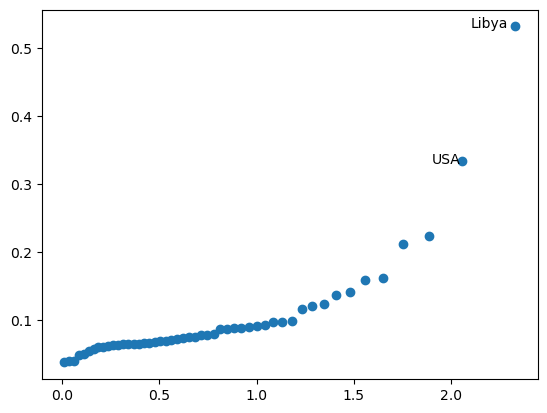

In [55]:
# Draw half-normal plot
n=50
ix = np.arange(1, n+1)
halfq = sp.stats.norm.ppf((n+ix)/(2*n+1)),
plt.scatter(halfq, np.sort(hatv))
plt.annotate("Libya",(2.1,0.53)); plt.annotate("USA", (1.9,0.33));

- Since the variance of the residuals is given by $var(\hat{\epsilon}_i) = \sigma^2 (1-h_i)$, then it suggests using the formula: $r_i=\frac{{\hat{\varepsilon}}_i}{\hat{\sigma}\sqrt{1-h_i}}$
- This is called the standardized residual (Pearson residuals).
- Standardized residuals are often preferred in residual plots because they have been adjusted to have equal variance.
- If the model assumptions are correct, then $var(r_i)$ will be 1, and the correlation between ($r_i$) and ($r_j$), the $corr(r_i,r_j)$, will tend to be small.
- Standardization can only fix the natural nonconstant variance in residuals if the errors have constant variance. However, if the errors have changing variance (heteroscedasticity), standardization won’t be able to correct it.

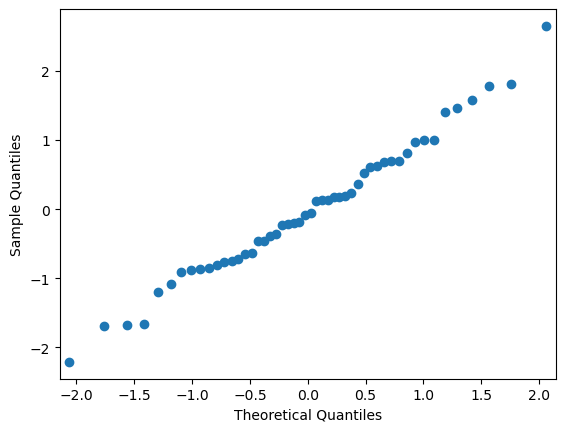

In [56]:
# In statsmodels, the residual found in lmod. resid_pearson only divides by σ^ 
# and does not include the leverage component.
# The more common definition of the Pearson residual, known as the internally studentized residual, 
# can be obtained from the get_influence() function.
rstandard = diagv.resid_studentized_internal
sm.qqplot(rstandard);

- Because these residuals are standardized, we expect the points to roughly follow the ( y = x ) line if normality holds.
- Another benefit of standardized residuals is that their size is easier to judge. An absolute value of 2 is large but not exceptional, while a value of 4 is very unusual under the standard normal distribution.
- Some authors recommend using standardized residuals instead of raw residuals in all diagnostic plots. However, in many cases, standardized residuals are similar to raw residuals except for the change in scale. Differences in the plot shape are noticeable only when there are unusually large leverages.

### 4.2.2. Outliers
- An outlier is a data point that stands out from the rest of the data. Outliers might or might not significantly affect the overall fit of the data. An outlier test helps us distinguish between genuinely exceptional data points and large residuals that aren’t necessarily unusual.
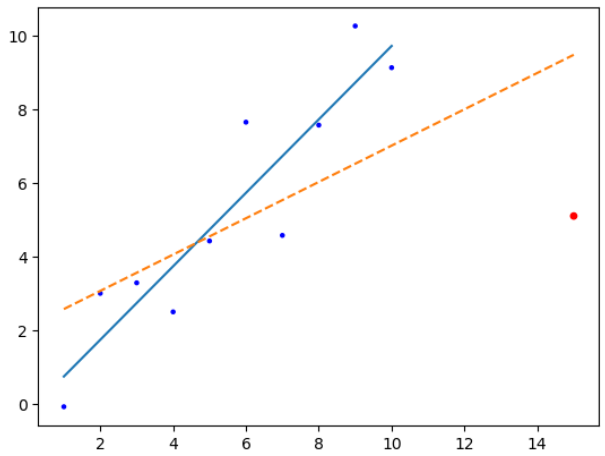
- This point has a large residual, and it also increases the residuals of other points. Therefore, it is both an outlier and an influential point. It’s important to identify such points because they can greatly affect the analysis. Simply looking at residuals can miss these tricky observations, as they pull the regression line closer and hide their true impact.
- To detect such points, we exclude the specific point (i) and recalculate the estimates to obtain ${\hat{\beta}}_{\left(i\right)}$ and ${\hat{\sigma}}_{\left(i\right)}^2$, where (i) indicates that the i-th case has been excluded.
    - ${\hat{y}}_{\left(i\right)}=x_i^\prime{\hat{\beta}}_{\left(i\right)}$
    - If ${\hat{y}}_{\left(i\right)}-y_i$ is large, then case i is an outlier.
    - To judge the size of a potential outlier, we need an appropriate scaling.
        - $\widehat{var}{\left(y_i-{\hat{y}}_{\left(i\right)}\right)}={\hat{\sigma}}_{\left(i\right)}^2\left(1+x_i^\prime\left(X_{\left(i\right)}^\prime X_{\left(i\right)}\right)^{-1}x_i\right)$
        - We define the studentized (jackknife or crossvalidated) residuals: $t_i=\frac{y_i-{\hat{y}}_{\left(i\right)}}{{\hat{\sigma}}_{(i)}\sqrt{1+x_i^\prime\left(X_{\left(i\right)}^\prime X_{\left(i\right)}\right)^{-1}x_i}}$.
        - If the model correct and ${\varepsilon} \sim N(0,\sigma^2{I})$, then $t_i \sim t_{n-p-1}$.
        - An easier way to compute: $t_i=\frac{{\hat{\varepsilon}}_i}{{\hat{\sigma}}_{(i)}\sqrt{1-h_i}}=r_i\ \left(\frac{n-p-1}{n-p-r_i^2}\right)^\frac{1}{2}\ \sim t_{n-p-1}$. It avoids doing n regressions.
- Since $t_i \sim t_{n-p-1}$, we can calculate a p-value to test if case ( i ) is an outlier. This works well if we only test one preselected case. However, if we have ( n = 100 ) and test all cases, we would expect to find about five outliers at a 5% significance level. Even if we explicitly test only one or two large ($ t_i $) values, we are implicitly testing all cases because we need to consider all residuals to identify the large ones. Therefore, we need to adjust the test level to avoid identifying too many outliers.
- Suppose we want a test with significance level ( $\alpha$ ). The probability that all tests accept is ($ 1 - P(\text{at least one rejects}) \approx 1 - n\alpha $). This suggests that if we want an overall level ( $\alpha$ ) test, we should use a level ($ \alpha/n $) for each individual test (because $n\times\alpha^\ast=n\times\frac{\alpha}{n}=\alpha$) . This method is called the Bonferroni correction and is used in various contexts, not just for outliers. Its main drawback is that it is conservative, meaning it finds fewer outliers than the nominal confidence level would suggest. The larger ( n ) is, the more conservative it becomes.
    - The Bonferroni correction is a statistical method used to adjust the significance level when performing multiple tests. It reduces the chance of false positives by ensuring the overall confidence level remains accurate, thus controlling the risk of Type I errors (false positives).

In [57]:
# In statsmodels, this studentized residual is known as the externally studentized residual 
# and can be obtained from the get_influence() function.
stud = pd.Series(diagv.resid_studentized_external, savings.index)
(pd.Series.idxmax(abs(stud)), np.max(abs(stud)))

('Zambia', 2.8535583382283916)

In [58]:
# Calculate the critical value: α=0.05, divided by 2 because 2 sided test, n = 50 -> n-p-1=44
abs(sp.stats.t.ppf(0.05/(2*50), 44))

3.525801306486005

- Since 2.85 is less than 3.53, we conclude that Zambia is not an outlier.
- For simple regression, the minimum critical value is 3.51 when ( n = 23 ). This means it’s not worth calculating the outlier test p-value unless the studentized residual is greater than about 3.5 in absolute value. 

#### Four points:
- Two or more outliers next to each other can hide each other.
- An outlier in one model may not be an outlier in another when the variables have been changed or transformed. We will usually need to reinvestigate the question of outliers when we change the model.
- The error distribution might not always be normal, so larger errors can happen occasionally, even if most errors follow a normal pattern. For example, stock prices usually change in small, predictable ways, but sometimes they can change significantly and unexpectedly, deviating from the usual pattern.
- In larger datasets, individual outliers have less impact on the overall fit. However, it’s still important to identify them for valuable insights. The focus should be on clusters of outliers, as they are less likely to be random and more likely to indicate meaningful patterns. Identifying these clusters can be challenging.

#### To dos for outliers:
- Check for a data-entry error first. If we can be sure that the point is truly a mistake and was not actually observed, discard it.
- Finding an outlier can lead to exciting scientific discoveries. For instance, unexpected data anomalies might reveal new insights or breakthroughs. In credit card transactions, outliers can indicate fraudulent activity.
- Exclude the point from the analysis but try reincluding it later if the model is changed.
- If outliers are natural and not errors, we should use robust regression, a method designed to handle outliers effectively. Simply removing outliers and using least squares regression might not give accurate results. Instead, we need to adjust our prediction methods to account for the possibility of extreme values. This ensures our predictions consider the uncertainty or confidence in the presence of outliers.
- It is dangerous to exclude outliers in an automatic manner.

### 4.2.3. Influential observations
- An influential point is one that, if removed, would significantly change the fit of the model. It might be an outlier or have high leverage, but it usually has at least one of these characteristics.
- Measure of influence:
    - Subscripts (i) indicates the fit without case i.
    - We can measure the change in the fit, ${X}^\prime(\hat{{\beta}}-\ {\hat{{\beta}}}_{\left(i\right)}\ )\ =\hat{{y}}-\ {\hat{{y}}}_{\left(i\right)}$, but there is a vector of (n-1) length to examine.
    - Thus, we might consider only the change in the coefficient $\hat{{\beta}}-\ {\hat{{\beta}}}_{\left(i\right)}$.
    - The Cook statistics are popular influence diagnostics because they reduce the information to a single value for each case.
        - $D_i=\frac{\left(\hat{{y}}-\ {\hat{{y}}}_{\left(i\right)}\right)^\prime\left(\hat{{y}}-\ {\hat{{y}}}_{\left(i\right)}\right)}{p{\hat{\sigma}}^2}=\frac{1}{p}r_i^2\frac{h_i}{1-h_i}\ $
        - $r_i^2$ is the residual effect. $\frac{h_i}{1-h_i}$ is the leverage. The combination of the two leads to influence.
        - A half-normal plot of Di can be used to identify influential observations.

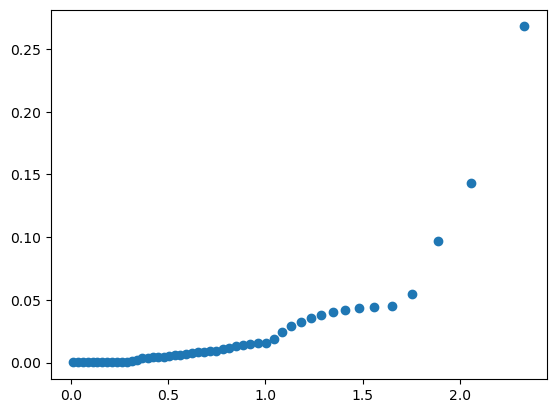

In [59]:
cooks = pd.Series(diagv.cooks_distance[0], savings.index)
n=50
ix = np.arange(1,n+1)
halfq = sp.stats.norm.ppf((n+ix)/(2*n+1)),
plt.scatter(halfq, np.sort(cooks));

In [60]:
# The largest five values of Cook statistics
cooks.sort_values().iloc[-5:]

Philippines    0.045221
Ireland        0.054396
Zambia         0.096633
Japan          0.142816
Libya          0.268070
dtype: float64

In [61]:
# Eclude Libya and see how the fit changes
lmodi = smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', savings[cooks < 0.2]).fit()
pd.DataFrame({'with':lmod.params, 'without':lmodi.params})

,with,without
Intercept,28.566087,24.524046
pop15,-0.461193,-0.391440
pop75,-1.691498,-1.280867
dpi,-0.000337,-0.000319
ddpi,0.409695,0.610279


Among other changes, we see that the coefficient for ddpi changed by about 50%. We don’t want our estimates to be so sensitive to just one country. Instead of leaving out each country one by one, we look at the differences in the coefficients when each country is left out.

In [62]:
# Extract DFBETAS for pop15. DFBETAS stands for "Difference in Betas." 
# It measures the change in each regression coefficient when an  observation is removed from the dataset.
p15d = diagv.dfbetas[:, 1]
diagv.dfbetas.shape

(50, 5)

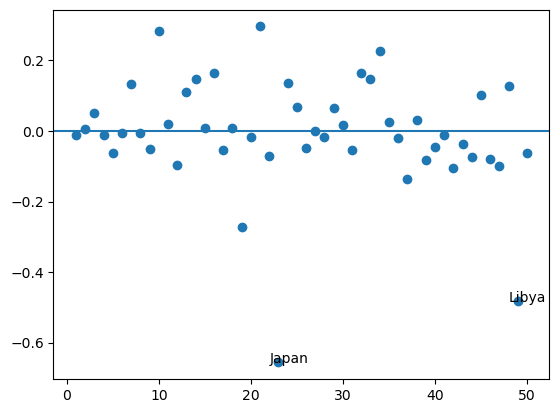

In [63]:
# Plot DFBETAS for pop15
plt.scatter(np.arange(1,51), p15d)
plt.axhline(0)
# Annotate Japan and Libya
ix = 22; plt.annotate(savings.index[ix], (ix, p15d[ix]))
ix = 48; plt.annotate(savings.index[ix], (ix, p15d[ix]));

We plotted the change in the second parameter estimate (~popI5) when a case is left out. This process should be repeated for the other variables. Japan stands out in this plot, so we examine the effect of removing it.

In [64]:
lmodj = smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', 
    savings.drop(['Japan'])).fit()
lmodj.sumary()

           coefs stderr tvalues pvalues
Intercept 23.940  7.784    3.08  0.0036
pop15     -0.368  0.154   -2.39  0.0210
pop75     -0.974  1.155   -0.84  0.4040
dpi       -0.000  0.001   -0.51  0.6112
ddpi       0.335  0.198    1.69  0.0987

n=49 p=5 Residual SD=3.738 R-squared=0.28


Comparing this to the full data fit, we see several changes. The ddpi term is no longer significant, and the R² value has decreased a lot.

## 4.3. Structure of the model
- The plots of the residuals $\hat{\varepsilon}$ against the predicted values $\hat{y}$ and the predictor variables $x_i$ are used to check the assumptions about the errors in the model. However, they can also provide insights into possible transformations of the variables that could improve the structure of the model.
- We can make plots of y against each $x_i$. However, the relationship between a specific predictor and the response variable can be influenced by other predictors. To isolate the effect of a specific predictor (referred to as $x_i$) on the response variable (referred to as y), we can use partial regression (added variable) plots:
    - First, we predict the response variable (y) using all predictors except the one we’re interested in ($x_i$). This gives us the leftover part (residuals represented as $\hat{{\delta}}$), which shows the response variable with the influence of other predictors removed.
    - Similarly, we regress the specific predictor ($x_i$) on all predictors except itself ($x_i$). This gives us the residuals (represented as $\hat{\gamma}$), which represent the effect of the specific predictor with the influence of other predictors removed.
    - The added variable plot is then created by plotting the residuals ($\hat{\delta}$) against the residuals ($\hat{\gamma}$). This plot helps us identify non-linear relationships, outliers, and influential observations.
- A partial regression (added variable) plot helps us understand regression coefficients by showing the relationship between a specific predictor and the response variable, after removing the effects of other predictors. In multiple regression, visualizing the relationship between each predictor and the response can be challenging due to the presence of multiple predictors. The partial regression plot simplifies this by focusing on one predictor at a time, similar to a simple regression model with just one predictor. By isolating the effects of other predictors, it helps us see the individual contribution of each predictor to the response variable.

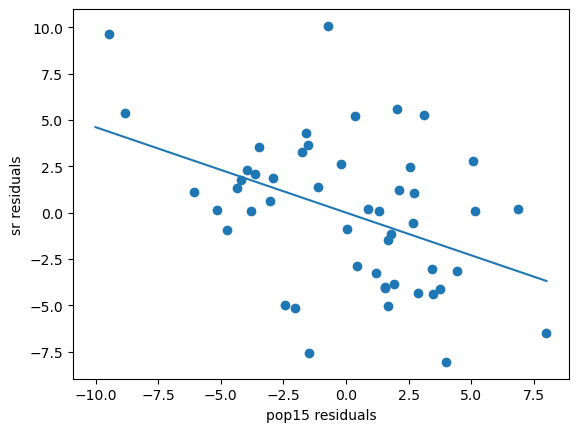

In [65]:
# Examine the variable pop15
d = smf.ols('sr ~ pop75 + dpi + ddpi', savings).fit().resid
m = smf.ols('pop15 ~ pop75 + dpi + ddpi', savings).fit().resid
plt.scatter(m, d)
plt.xlabel("pop15 residuals"); plt.ylabel("sr residuals")
# Plot a line from the point (-10, -10*beta_pop15) to the point (8, 8*beta_pop15)
plt.plot([-10, 8], [-10*lmod.params.iloc[1], 8*lmod.params.iloc[1]]);

The function np.polyfit(m, d, deg=1) is used to perform a polynomial fit (linear regression in this case) on the data points (m, d). Here's a detailed breakdown:

    m: This is the array of x-coordinates (independent variable).
    d: This is the array of y-coordinates (dependent variable).
    deg=1: This specifies the degree of the polynomial to fit. deg=1 means a linear fit (i.e., fitting a straight line).

The function returns the coefficients of the polynomial, starting with the highest degree term. For a linear fit, it returns two coefficients: the slope and the intercept of the best-fit line.

In [66]:
np.polyfit(m,d,deg=1), lmod.params.iat[1]

(array([-4.61193147e-01, -3.80967234e-13]), -0.4611931471227622)

- Partial residual plots serve as an alternative to added variable plots.
    - $y-\sum_{j\neq i}{x_j{\hat{\beta}}_j}=\hat{y}+\hat{\varepsilon}-\sum_{j\neq i}{x_j{\hat{\beta}}_j}=x_i{\hat{\beta}}_i+\hat{\varepsilon}$
    - The partial residual plots is then $x_i{\hat{\beta}}_i+\hat{\varepsilon}$ against $x_i$.
    - The slope of the plot is ${\hat{\beta}}_i$.
    - Partial residual plots are better for non-linearity detection, while added variable plots are better for outlier/influential detection.
    - In some versions of this plot, the partial residuals are centered, which only changes the vertical axis scale.

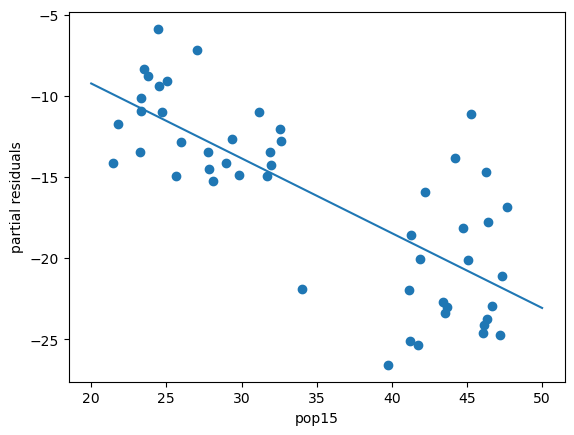

In [67]:
pr = lmod.resid + savings.pop15*lmod.params.iat[1]
plt.scatter(savings.pop15, pr)
plt.xlabel("pop15"); plt.ylabel("partial residuals")
# Plot a line from the point (20, 20*beta_pop15) to the point (50, 50*beta_pop15)
plt.plot([20,50], [20*lmod.params.iat[1], 50*lmod.params.iat[1]]);

The plot shows two groups. This suggests there might be different relationships in these groups. Let’s investigate this further:

In [68]:
smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', savings[savings.pop15 > 35]).fit().sumary()

           coefs stderr tvalues pvalues
Intercept -2.434 21.155   -0.12  0.9097
pop15      0.274  0.439    0.62  0.5408
pop75     -3.548  3.033   -1.17  0.2573
dpi        0.000  0.005    0.08  0.9339
ddpi       0.395  0.290    1.36  0.1896

n=23 p=5 Residual SD=4.454 R-squared=0.16


In [69]:
smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', savings[savings.pop15 < 35]).fit().sumary()

           coefs stderr tvalues pvalues
Intercept 23.962  8.084    2.96  0.0072
pop15     -0.386  0.195   -1.98  0.0609
pop75     -1.328  0.926   -1.43  0.1657
dpi       -0.000  0.001   -0.63  0.5326
ddpi       0.884  0.295    2.99  0.0067

n=27 p=5 Residual SD=2.772 R-squared=0.51


- In the first regression for underdeveloped countries (pop15>35%), we find no link between the predictors and the response. This isn’t due to outliers or unexpected transformations, as we’ve checked before. However, in developed countries (pop15<35%), there’s a strong relationship. The strongest predictor is growth, along with some link to the proportion of the population under 15. This effect is less noticeable now because we’ve narrowed the range of this predictor by subsetting. 
- The graphical analysis revealed a relationship that a purely numerical analysis might have missed.
- Sometimes, adding extra dimensions to diagnostic plots using color, symbols, or size can be helpful. Alternatively, we can use faceted plots.





In [70]:
savings.head(3)

,sr,pop15,pop75,dpi,ddpi
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82


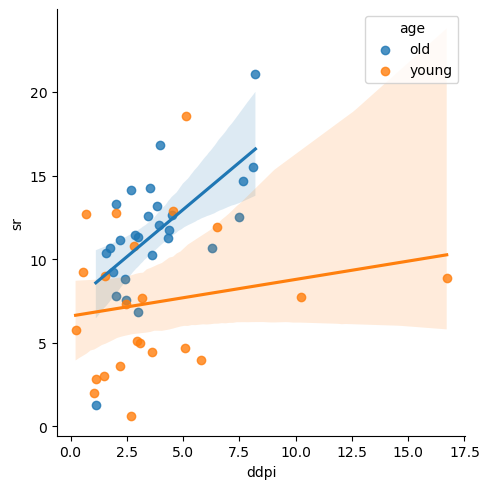

In [71]:
savings['age'] = np.where(savings.pop15 > 35, 'young', 'old')
sns.lmplot(x='ddpi', y='sr', data=savings, hue='age', facet_kws={"legend_out": False});

- sns.lmplot: A Seaborn function to plot data and fit a linear regression model.
- x=‘ddpi’: Uses the ‘ddpi’ column from the savings DataFrame for the x-axis.
- y=‘sr’: Uses the ‘sr’ column from the savings DataFrame for the y-axis.
- data=savings: Specifies the savings DataFrame for the plot.
- hue=‘age’: Colors data points based on the ‘age’ column, which has categories ‘young’ and ‘old’.
- facet_kws={“legend_out”: False}: Keeps the legend inside the plot.

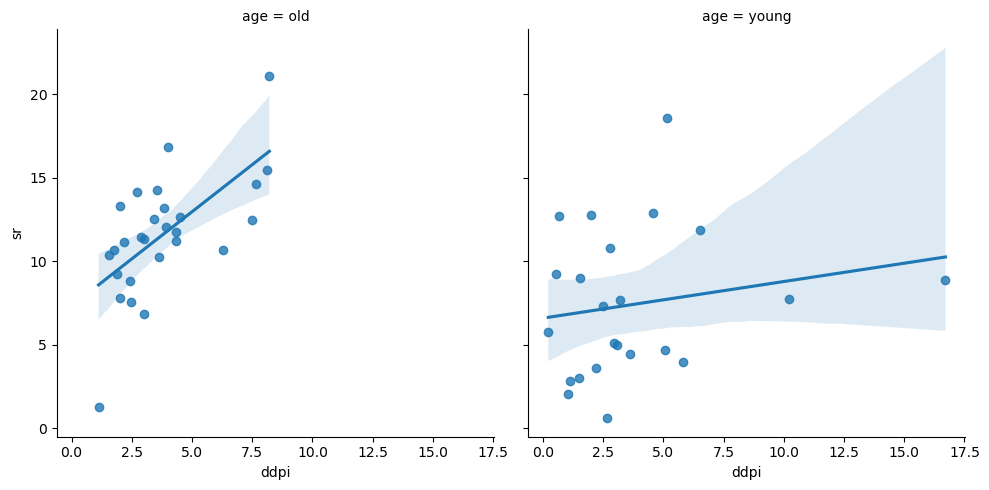

In [72]:
sns.lmplot(x='ddpi', y='sr', data=savings, col='age');

- The plots show two ways to distinguish the levels of the status variable based on the population proportion under 15. The second set of plots is more effective. We’ve added a regression line with 95% confidence bands to clearly show how the relationship differs between the two groups.
- Higher-dimensional plots can help detect structures that aren’t visible in two dimensions. These plots are usually interactive, so you need to try them out to understand how they work. We can create three-dimensional plots using color, point size, and rotation to simulate a third dimension. We can also link multiple plots so that selecting points in one plot highlights them in another. While these tools look impressive, their practical usefulness is uncertain, and they are hard to print.

## 4.4. Discussion
- The following is sorted after their importance of the effects.
- The systematic form of the model: It’s essential to correctly define how variables relate to each other. If done incorrectly, predictions will be wrong, and any interpretation of the relationships may be biased and misleading.
- Dependence of errors: When errors are strongly dependent, the data contains less information than the sample size suggests. This can lead analysts to mistakenly add systematic components to the model to address unexpected error dependence. Detecting this dependence is challenging with regression diagnostics, except in cases like temporal data. For other data types, analysts must rely on assumptions about independence based on their contextual knowledge, which are harder to test.
- Nonconstant variance: Ignoring this violation of linear model assumptions can lead to inaccurate inferences, especially in predicting uncertainty. However, unless the violation is severe, the overall reliability of the inferences may not be greatly affected.
- Normality: This is the least critical assumption. For large datasets, inferences are quite robust even if normality is lacking, thanks to the central limit theorem, which ensures approximations are generally adequate. Unless the sample size is very small or the errors are extremely abnormal, this assumption is not crucial for success.

# 6. Changes of Scale
- Sometimes, we need to change the scale of variables by converting units or adjusting very large or small values. This makes numbers more manageable and easier to interpret.
- In extreme cases, changing the scale may be necessary for numerical stability and to prevent calculation errors. Most algorithms perform better when variables are on similar scales.
- Rescaling variables does not affect statistical tests like t-tests, F-tests, variance, and R-squared. However, it impacts estimated coefficients and standard deviation. Scaling to standard units (mean 0, variance 1) simplifies comparisons, ensures coefficients are within a specific range, and avoids numerical issues with different scales. This is useful for plots and binary predictors.
- If we rescale $ x_i $ as $ \frac{x_i + a}{b} $, the t-tests, F-tests, $ \sigma^2 $, and $ R^2 $ remain unchanged. However, the estimated coefficients $ \hat{\beta}_i $ will be scaled by $ b\hat{\beta}_i $. Similarly, rescaling $ y $ leaves the t-tests, F-tests, and $ R^2 $ unchanged, but the estimated coefficients $ \hat{\beta} $ and the estimated standard deviation $ \hat{\sigma} $ will be scaled by $ b $.
- Converting variables to standard units (mean 0, variance 1) has several advantages:
    - Comparable Scale: All predictors and the response variable are on the same scale, making comparisons easier.
    - Partial Correlation: Regression coefficients, now between -1 and 1, indicate the strength and direction of relationships.
    - Numerical Stability: Centering avoids issues from different variable scales, ensuring stable calculations.
    - Standard Interpretation: Coefficients show the effect of a one standard deviation increase in the predictor on the response.

In [78]:
# Reload the data again
savings_sclDF = faraway.datasets.savings.load()
# Run a regression
lmod = smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', savings_sclDF).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept 28.566  7.355    3.88  0.0003
pop15     -0.461  0.145   -3.19  0.0026
pop75     -1.691  1.084   -1.56  0.1255
dpi       -0.000  0.001   -0.36  0.7192
ddpi       0.410  0.196    2.09  0.0425

n=50 p=5 Residual SD=3.803 R-squared=0.34


In [79]:
# Change the scale
lmod = smf.ols('sr ~ pop15 + pop75 + I(dpi/1000) + ddpi', savings_sclDF).fit()
lmod.sumary()

               coefs stderr tvalues pvalues
Intercept     28.566  7.355    3.88  0.0003
pop15         -0.461  0.145   -3.19  0.0026
pop75         -1.691  1.084   -1.56  0.1255
I(dpi / 1000) -0.337  0.931   -0.36  0.7192
ddpi           0.410  0.196    2.09  0.0425

n=50 p=5 Residual SD=3.803 R-squared=0.34


In [80]:
# Convert all the variables to standard units (mean O and variance 1)
scsav = savings_sclDF.apply(sp.stats.zscore)
lmod = smf.ols('sr ~ pop15 + pop75 + dpi + ddpi', scsav).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept  0.000  0.121    0.00  1.0000
pop15     -0.942  0.295   -3.19  0.0026
pop75     -0.487  0.312   -1.56  0.1255
dpi       -0.075  0.206   -0.36  0.7192
ddpi       0.262  0.126    2.09  0.0425

n=50 p=5 Residual SD=0.857 R-squared=0.34


- When the predictors are on comparable scales, it can be helpful to construct a plot of the estimates with confidence intervals

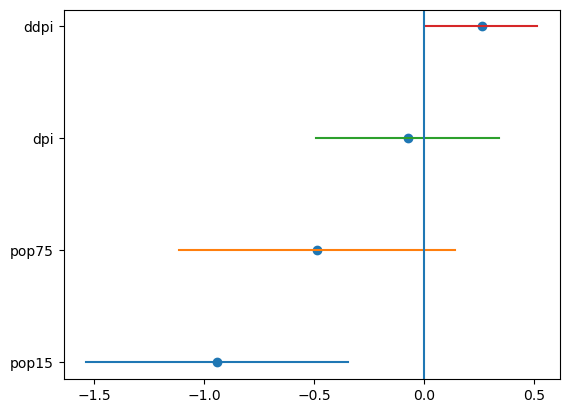

In [81]:
edf = pd.concat([lmod.params, lmod.conf_int()],axis=1).iloc[1:,]
edf.columns = ['estimate','lb','ub']
npreds = edf.shape[0]
fig, ax = plt.subplots()
ax.scatter(edf.estimate,np.arange(npreds))
for i in range(npreds):
    ax.plot([edf.lb.iat[i], edf.ub.iat[i]], [i, i])
ax.set_yticks(np.arange(npreds))
ax.set_yticklabels(edf.index)
ax.axvline(0);

- When dealing with binary predictors, scaling is different. A binary predictor with values 0 and 1 (equal probability) has a standard deviation of 0.5. Thus, continuous predictors should be scaled by two standard deviations (SDs) instead of one to match the binary predictor’s scale. Alternatively, using −1/+1 coding for the binary predictor allows standard scaling for continuous predictors.

In [82]:
# Create a age column
savings_sclDF['age'] = np.where(savings_sclDF.pop15 > 35, 0, 1)
# younger countries are coded as zero and older countries as one
savings_sclDF['dpis'] = sp.stats.zscore(savings_sclDF.dpi)/2
savings_sclDF['ddpis'] = sp.stats.zscore(savings_sclDF.ddpi)/2
smf.ols('sr ~ age + dpis + ddpis', savings_sclDF).fit().sumary()

           coefs stderr tvalues pvalues
Intercept  6.818  1.011    6.75  0.0000
age        5.284  1.585    3.33  0.0017
dpis      -1.549  1.593   -0.97  0.3361
ddpis      2.443  1.097    2.23  0.0309

n=50 p=4 Residual SD=3.800 R-squared=0.32


- Interpreting the coefficients is now simpler. Older countries have a savings rate 5.28% higher than younger ones, which is a difference of two standard deviations. Similarly, a two standard deviation change in ddpi corresponds to a one-unit difference in its new scale. Thus, a country with a high growth rate typically has a savings rate 2.47% higher than one with a low growth rate. Note that ddpi is a continuous variable, so this interpretation is for intuitive understanding.

# 7. Transformation
- When you use a log transformation on the response, the regression coefficients have a particular interpretation:
    - $\log{\hat{y}}={\hat{\beta}}_0+{\hat{\beta}}_1x_1+\ldots+{\hat{\beta}}_px_p$
    - $\hat{y}=e^{{\hat{\beta}}_0}e^{{\hat{\beta}}_1x_1}\ldots e^{{\hat{\beta}}_px_p}$
    - If we increase $x_1$ by one, the predicted response (in the original scale) is multiplied by ( $e^{\hat{\beta}_1}$ ). In a log scale, regression coefficients multiply the response. For small x, ( $\log(1 + x) \approx x $). For example, if ( $\beta_1 = 0.09$ ), increasing ( $x_1$ ) by one raises ( $\log(y)$ ) by 0.09, or y by 9%. This works well for x up to about ($\pm 0.25$).
- The Box-Cox method transforms positive responses y to $g_λ(y)$, with transformations based on λ:
    - $g\lambda\left(y\right)=\left\{\begin{matrix}\frac{y^\lambda-1}{\lambda}&\lambda\neq0\\\log{y}&\lambda=0\\\end{matrix}\right.$
    - For a fixed $y > 0$, $g_\lambda(y)$ changes smoothly with $\lambda$. We can choose the optimal $\lambda$ using maximum likelihood, which assumes model errors follow a normal distribution. The profile log-likelihood measures how well the model fits the data under this assumption:
        - $L\left(\lambda\right)=\ -\frac{n}{2}\log{\left(\frac{RSS_\lambda}{n}\right)}+\left(\lambda-1\right)\sum\log{y_i}$
            - RSS$_λ$ is the residual sum of squares when $g_λ(y)$ is the response.
            - We find the best value $\hat{\lambda}$ using a numerical method to maximize the profile log-likelihood.
        - If using the regression model for prediction, we can take $y^\lambda$ as the response. The expression $\frac{y^\lambda - 1}{\lambda}$ is not required, as it's only used to ensure $g_\lambda$ smoothly transitions to the natural logarithm as $\lambda \to 0$.
        - To make the model easier to explain, we may round $\lambda$ to a more interpretable value. For instance, if $\hat{\lambda} = 0.46$, the transformed response might be difficult to explain. However, rounding $\lambda$ to 0.5 allows us to describe the response as $\sqrt{y}$, which is simpler to understand.
- Transforming the response complicates the model, so it should only be done if necessary. One way to check is by constructing a confidence interval for $\lambda$. A $100(1-\alpha)%$ confidence interval for $\lambda$ is:
    - $\left\{\lambda:L\left(\lambda\right)>L\left(\hat{\lambda}\right)-1/2\chi_{1,1-\alpha}^2\right\}$
    - The interval is derived by inverting the likelihood ratio test for the hypothesis $H_0: \lambda = \lambda_0$. The test uses the statistic $2\left(L\left(\hat{\lambda}\right) - L\left(\lambda_0\right)\right)$, which follows an approximate $\chi_1^2$ distribution under the null. The confidence interval also indicates how much rounding $\lambda$ for interpretability is reasonable.

In [6]:
# Extracts the exogenous variables matrix X from the fitted model.
X = lmod.model.wexog

In [7]:
# Setting Up Variables for Box-Cox Transformation
n = savings.shape[0] # number of observations in the dataset
sumlogy = np.sum(np.log(savings.sr)) # sum of log of sr
lam = np.linspace(0.5, 1.5, 100) # array of 100 lambda values ranging from 0.5 to 1.5
llk = np.empty(100) # empty array to store log-likelihood values

In [8]:
# Calculating Log-Likelihood for Each Lambda
# Iterates over each lambda value. Applies the Box-Cox transformation to the sr variable.
# Fits an OLS model with the transformed sr and calculates the log-likelihood.
for i in range(0, 100):
    lmod = sm.OLS(sp.stats.boxcox(savings.sr, lam[i]), X).fit()
    llk[i] = -(n/2)*np.log(lmod.ssr/n) + (lam[i]-1)*sumlogy

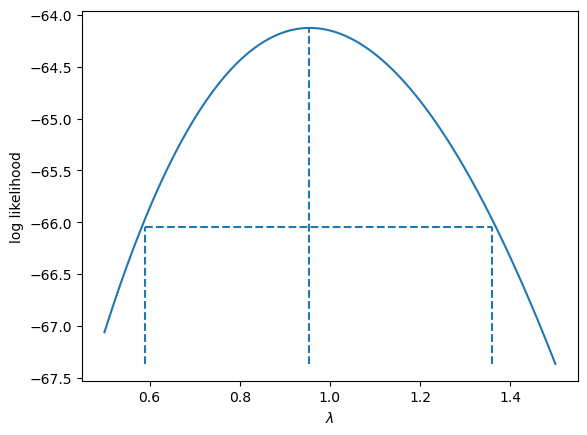

In [13]:
# Plotting the Log-Likelihood Values
fig, ax = plt.subplots()
ax.plot(lam, llk)
ax.set_xlabel('$\lambda$'); ax.set_ylabel('log likelihood')
# Highlighting the Maximum Log-Likelihood
maxi = llk.argmax()
ax.vlines(lam[maxi], ymin=min(llk), ymax=max(llk), linestyle='dashed')
# Calculating and Plotting Confidence Intervals
# Calculates the cutoff for the 95% confidence interval
cicut = max(llk) - sp.stats.chi2.ppf(0.95, 1) / 2
# Identifies the range of lambda values within this confidence interval
rlam = lam[llk > cicut]
# Draws horizontal and vertical dashed lines to indicate the confidence interval on the plot.
ax.hlines(cicut, xmin=rlam[0], xmax=rlam[-1], linestyle='dashed')
ax.vlines([rlam[0], rlam[-1]], ymin=min(llk), ymax=cicut, linestyle='dashed');

- In the computation, we used the search range [0.5, 1.5].
- We might need a wider range to capture the maximum and the confidence interval. This range was chosen based on prior testing. The confidence interval for $\lambda$ is roughly 0.6 to 1.4, suggesting there's no strong reason to transform.

# 8. Broken Stick Regression
- Sometimes, different parts of our data need separate linear regression models. For instance, in the savings data, we saw two distinct groups. Using the ‘pop15’ predictor, we can create two models: one for ‘pop15’ above 35% and one for ‘pop15’ below 35%.

In [5]:
# Fit linear models for two segments of the data
lmod1 = smf.ols('sr ~ pop15', savings[savings.pop15 < 35]).fit()
lmod2 = smf.ols('sr ~ pop15', savings[savings.pop15 > 35]).fit()

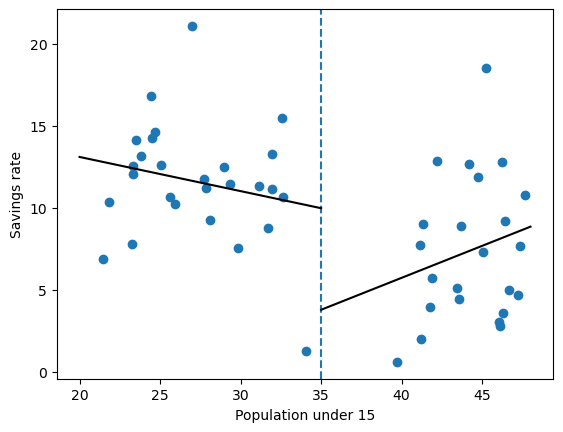

In [8]:
# Create scatter plot of the data
plt.scatter(savings.pop15, savings.sr)
plt.xlabel('Population under 15'); plt.ylabel('Savings rate')
# Add a vertical dashed line at pop15 = 35
plt.axvline(35, linestyle='dashed')
# Plot the first segment of the regression line
plt.plot([20, 35], [lmod1.params.iat[0] + lmod1.params.iat[1] * 20,
                    lmod1.params.iat[0] + lmod1.params.iat[1] * 35], 'k-')
# Plot the second segment of the regression line
plt.plot([35, 48], [lmod2.params.iat[0] + lmod2.params.iat[1] * 35,
                    lmod2.params.iat[0] + lmod2.params.iat[1] * 48], 'k-');

- A problem with using separate models for different data parts is the lack of connection at the split point. For a smoother transition between predictor values, we can use broken stick regression, which creates two new variables:
    - $B_l(x) = \begin{cases} 
        c - x & \text{if } x < c \\ 
        0 & \text{otherwise} 
      \end{cases}$    
    - $B_r(x) = \begin{cases} 
        x - c & \text{if } x > c \\ 
        0 & \text{otherwise} 
      \end{cases}$
- We designate a point ‘c’ to split the data into two groups and create two new variables, $B_l$ and $B_r$. These variables form a first-order spline basis with a knot at ‘c’, allowing the model to bend at this point for a better fit. Due to their shape, these variables are often referred to as hockey-stick functions.
- We then can fit a model of the form $y=\beta_0+\beta_1B_l\left(x\right)+\beta_2B_r\left(x\right)+\varepsilon$ by using regular regression methods.
- The two segments of the model converge at point ‘c’, ensuring continuity. Unlike the previous approach, which used four parameters (two regressions with two coefficients each), this model uses only three parameters. We achieve this by ensuring smoothness at point ‘c’, thereby saving one parameter.
- The intercept of this model is the value of the outcome where the two parts meet.

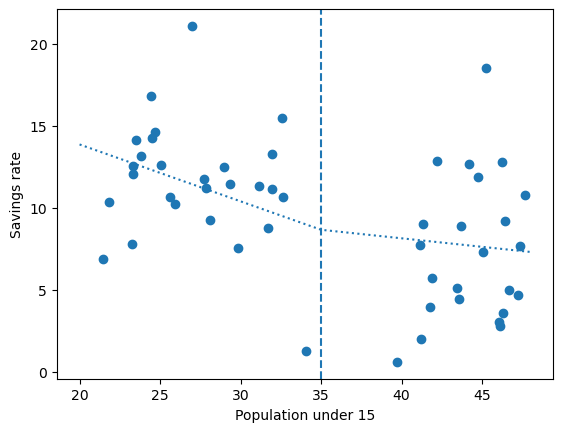

In [13]:
# Define helper functions for piecewise linear terms
def lhs(x, c):
    return np.where(x < c, c - x, 0)
def rhs(x, c):
    return np.where(x < c, 0, x - c)
# Fit the linear model using the piecewise terms
lmod = smf.ols('sr ~ lhs(pop15,35) + rhs(pop15,35)', savings).fit()
# Generate predictions
x = np.arange(20, 49) # array of values from 20 to 48
# Computes predicted savings rate (py) using the fitted model parameters
# and the lhs and rhs functions.
py = lmod.params.iat[0] + lmod.params.iat[1] * lhs(x, 35) + lmod.params.iat[2] * rhs(x, 35)
# Plot the piecewise linear regression line
plt.plot(x, py, linestyle='dotted')
# Create scatter plot of the data
plt.scatter(savings.pop15, savings.sr)
plt.xlabel('Population under 15'); plt.ylabel('Savings rate')
# Add a vertical dashed line at pop15 = 35
plt.axvline(35, linestyle='dashed');

- We might question which model is better. For countries with high ‘pop15’ values, enforcing smoothness changes the slope’s direction. Given the distinct differences between the two groups and the few countries in the middle, we might not want to force the model to be smooth.
- To make our model more flexible, we can add more bend points, called knotpoints, by creating new variables for each one. This approach, known as segmented regression or broken stick regression, can also allow knotpoints to change, making the model nonlinear and able to fit more complex data patterns.